# Mixing in the magnetic field of the Milky Way

In [1]:
# to import gammaALPs, this cell should be only executed once after kernel restart
%cd ..
%cd ..

/afs/desy.de/user/f/flandgra/private/GMF/gammaALPs/notebooks
/afs/desy.de/user/f/flandgra/private/GMF/gammaALPs


In [2]:
from gammaALPs.core import Source, ALP, ModuleList
from gammaALPs.base import environs, transfer
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patheffects import withStroke
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Circle, PathPatch
from matplotlib.text import TextPath
from matplotlib.transforms import Affine2D

import healpy as hp
import time

fatal: No names found, cannot describe anything.


In [3]:
effect  = dict(path_effects=[withStroke(foreground="w", linewidth=2)])  # used for plotting

Next we initialize the module. We assume a pure ALP beam as the initial state that enters the Milky Way.

In [4]:
EGeV = np.logspace(-1., 3., 101)  # the energy range, roughly matching the Fermi-LAT energy range
src = Source(z=0.017559, l=20., b=20.)  # some dummy source for initialization
pa_in = np.diag([0., 0., 1.])  # the inital polarization matrix; a pure ALP state

ml = [ModuleList(ALP(m=1., g=1.), src, pin=pa_in, EGeV=EGeV, seed=0) for i in range(8)]

models = ['base', 'expX', 'neCL', 'twistX', 'nebCor', 'cre10', 'synCG', 'spur']
for i in range(8):
    ml[i].add_propagation("GMF", 0, model='UF23', UF23_model=models[i])

environs.py:1206 --- INFO: Using inputted chi
environs.py:1206 --- INFO: Using inputted chi
environs.py:1206 --- INFO: Using inputted chi
environs.py:1206 --- INFO: Using inputted chi
environs.py:1206 --- INFO: Using inputted chi
environs.py:1206 --- INFO: Using inputted chi
environs.py:1206 --- INFO: Using inputted chi
environs.py:1206 --- INFO: Using inputted chi


## Compute conversion probability

In [5]:
px, py, pa = np.zeros((3, 8, EGeV.size))

In [6]:
prx, pry, pra = np.zeros((3, 8, 99, EGeV.size))

In [7]:
prx.shape

(8, 99, 101)

Compute the conversion probability along the line of sight. We provide the initial state and the final polarization state we're interested in.

In [8]:
px_in = np.diag([1., 0., 0.])
py_in = np.diag([0., 1., 0.])

for i in range(8):
    px[i], py[i], pa[i] = ml[i].run()
    prx[i] = (ml[i].modules["GMF"].show_conv_prob_vs_r(pa_in, px_in))
    pry[i] = (ml[i].modules["GMF"].show_conv_prob_vs_r(pa_in, py_in))
    pra[i] = (ml[i].modules["GMF"].show_conv_prob_vs_r(pa_in, pa_in))

   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixGMF'>
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixGMF'>
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixGMF'>
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixGMF'>
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixGMF'>
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixGMF'>
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixGMF'>
   core.py: 658 --- INFO: Running Module 0: <class 'gammaALPs.base.environs.MixGMF'>


Plot the conversion probability for one fixed energy as a function of propagation disctance together with the transversal magnetic field strength.

Energy: 3.981071705534973 GeV


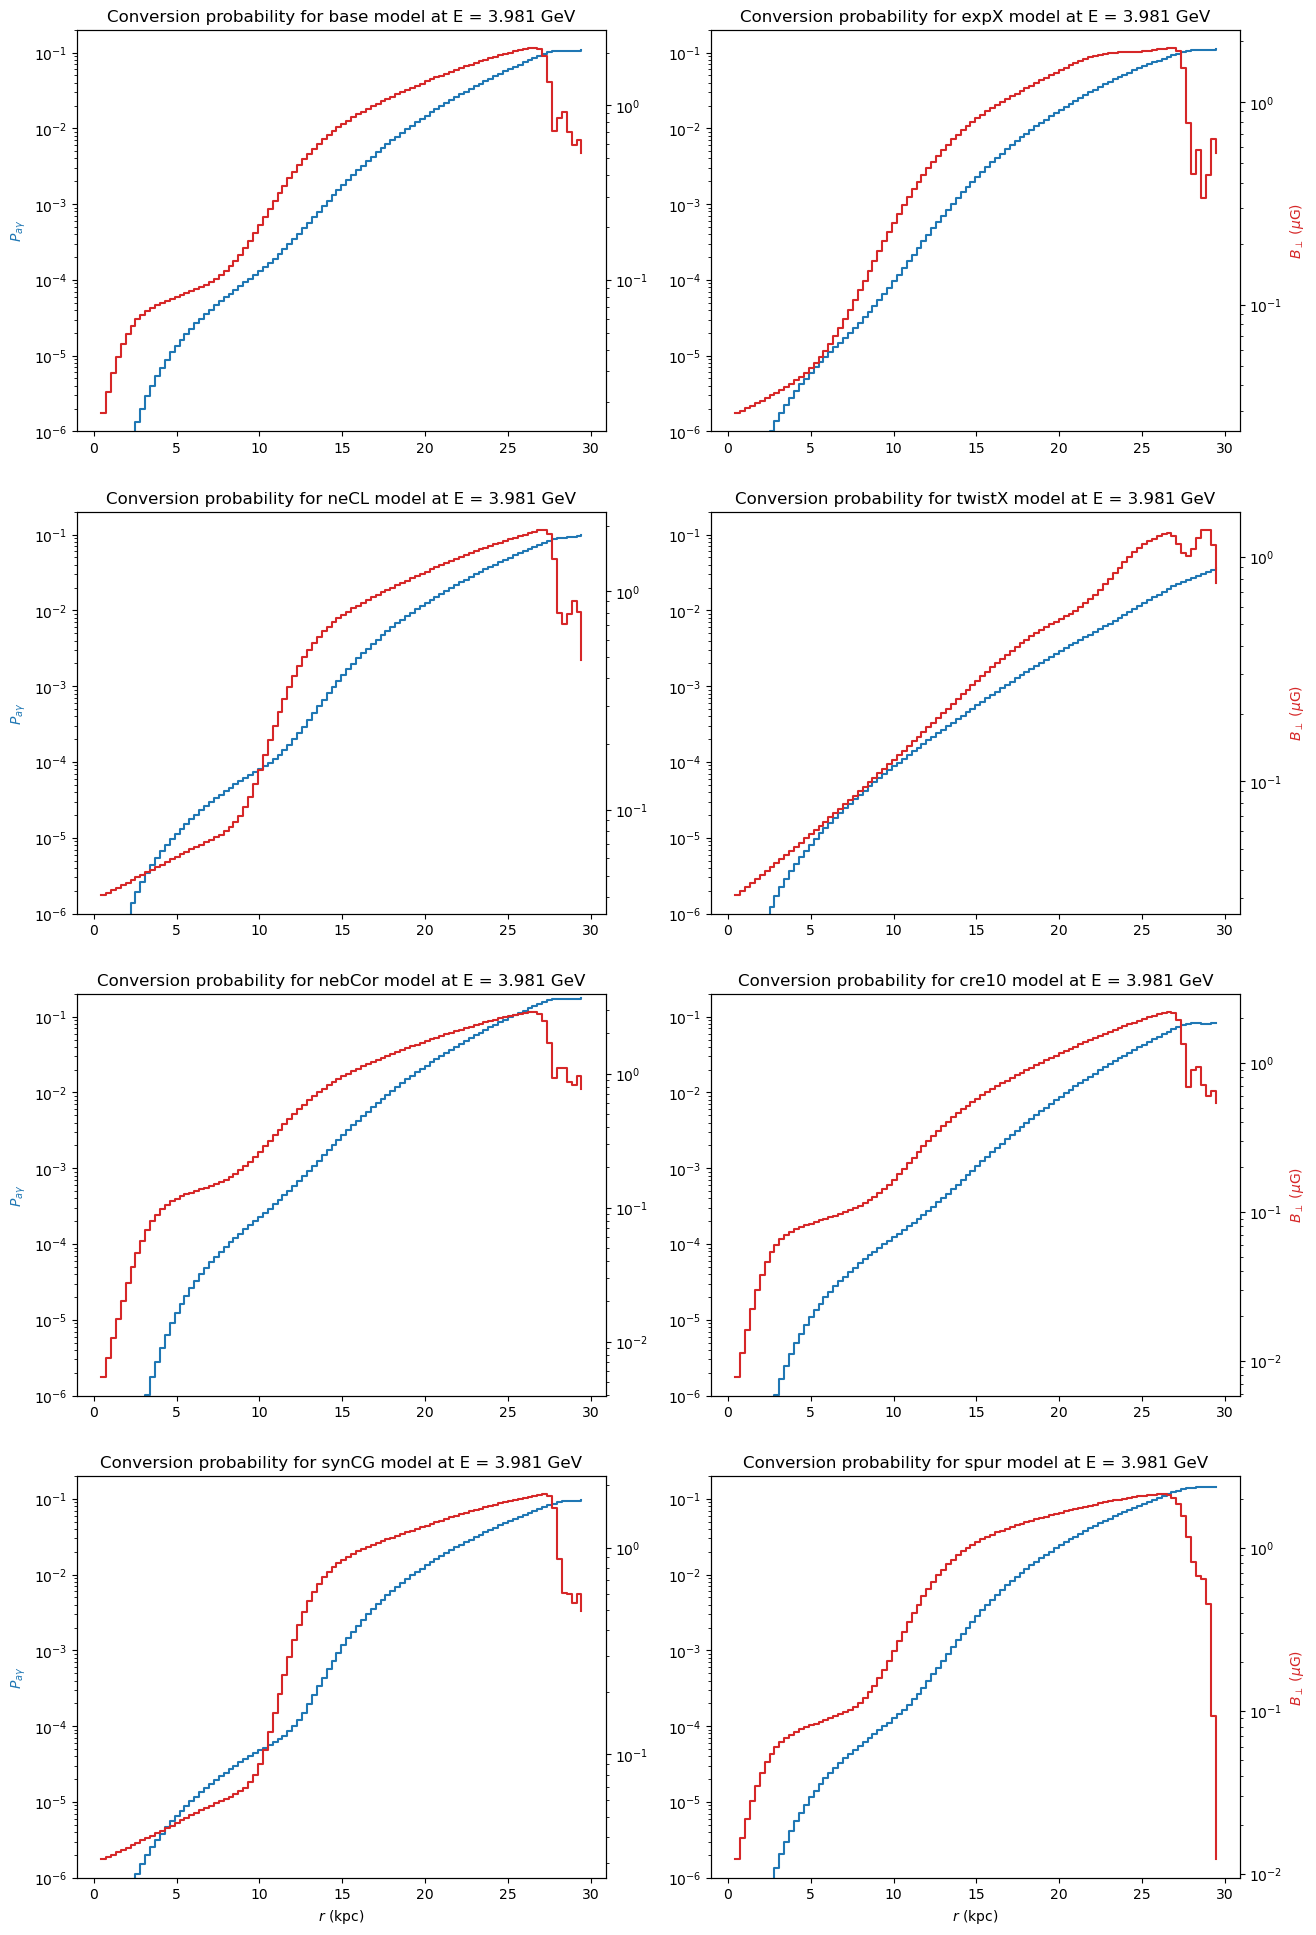

In [9]:
E = 4
idx = np.absolute(EGeV-E).argmin()
print ("Energy:", EGeV[idx], "GeV")

fig, axs = plt.subplots(4,2, figsize=(15, 24))

for i, ax in enumerate(axs.flat):
    ax.set_title(f"Conversion probability for {models[i]} model at E = {round(EGeV[idx],3)} GeV")
    ax.semilogy(ml[i].modules["GMF"].r, (prx[i][:,idx] + pry[i][:,idx])[::-1],
                drawstyle='steps')
    
    ax.set_ylabel(r"$P_{a \gamma}$", color = plt.cm.tab10(0.))
    ax.set_xlabel("$r$ (kpc)")
    ax.set_ylim(1e-6,2e-1)
    
    ax2 = ax.twinx()
    ax2.semilogy(ml[i].modules["GMF"].r, ml[i].modules["GMF"].B[::-1],
                 color = plt.cm.tab10(0.3),
                 drawstyle ='steps')
    
    ax2.set_ylabel(r"$B_{\perp}$ ($\mu$G)", color = plt.cm.tab10(0.3))
    ax.label_outer()
    ax2.label_outer()
    ax.tick_params(axis="both", which="both", labelbottom = True, labelleft = True)
    ax2.tick_params(axis="both", which="both", labelbottom = True, labelright = True)

plt.show()

### Plot the total conversion probability as a function of energy:

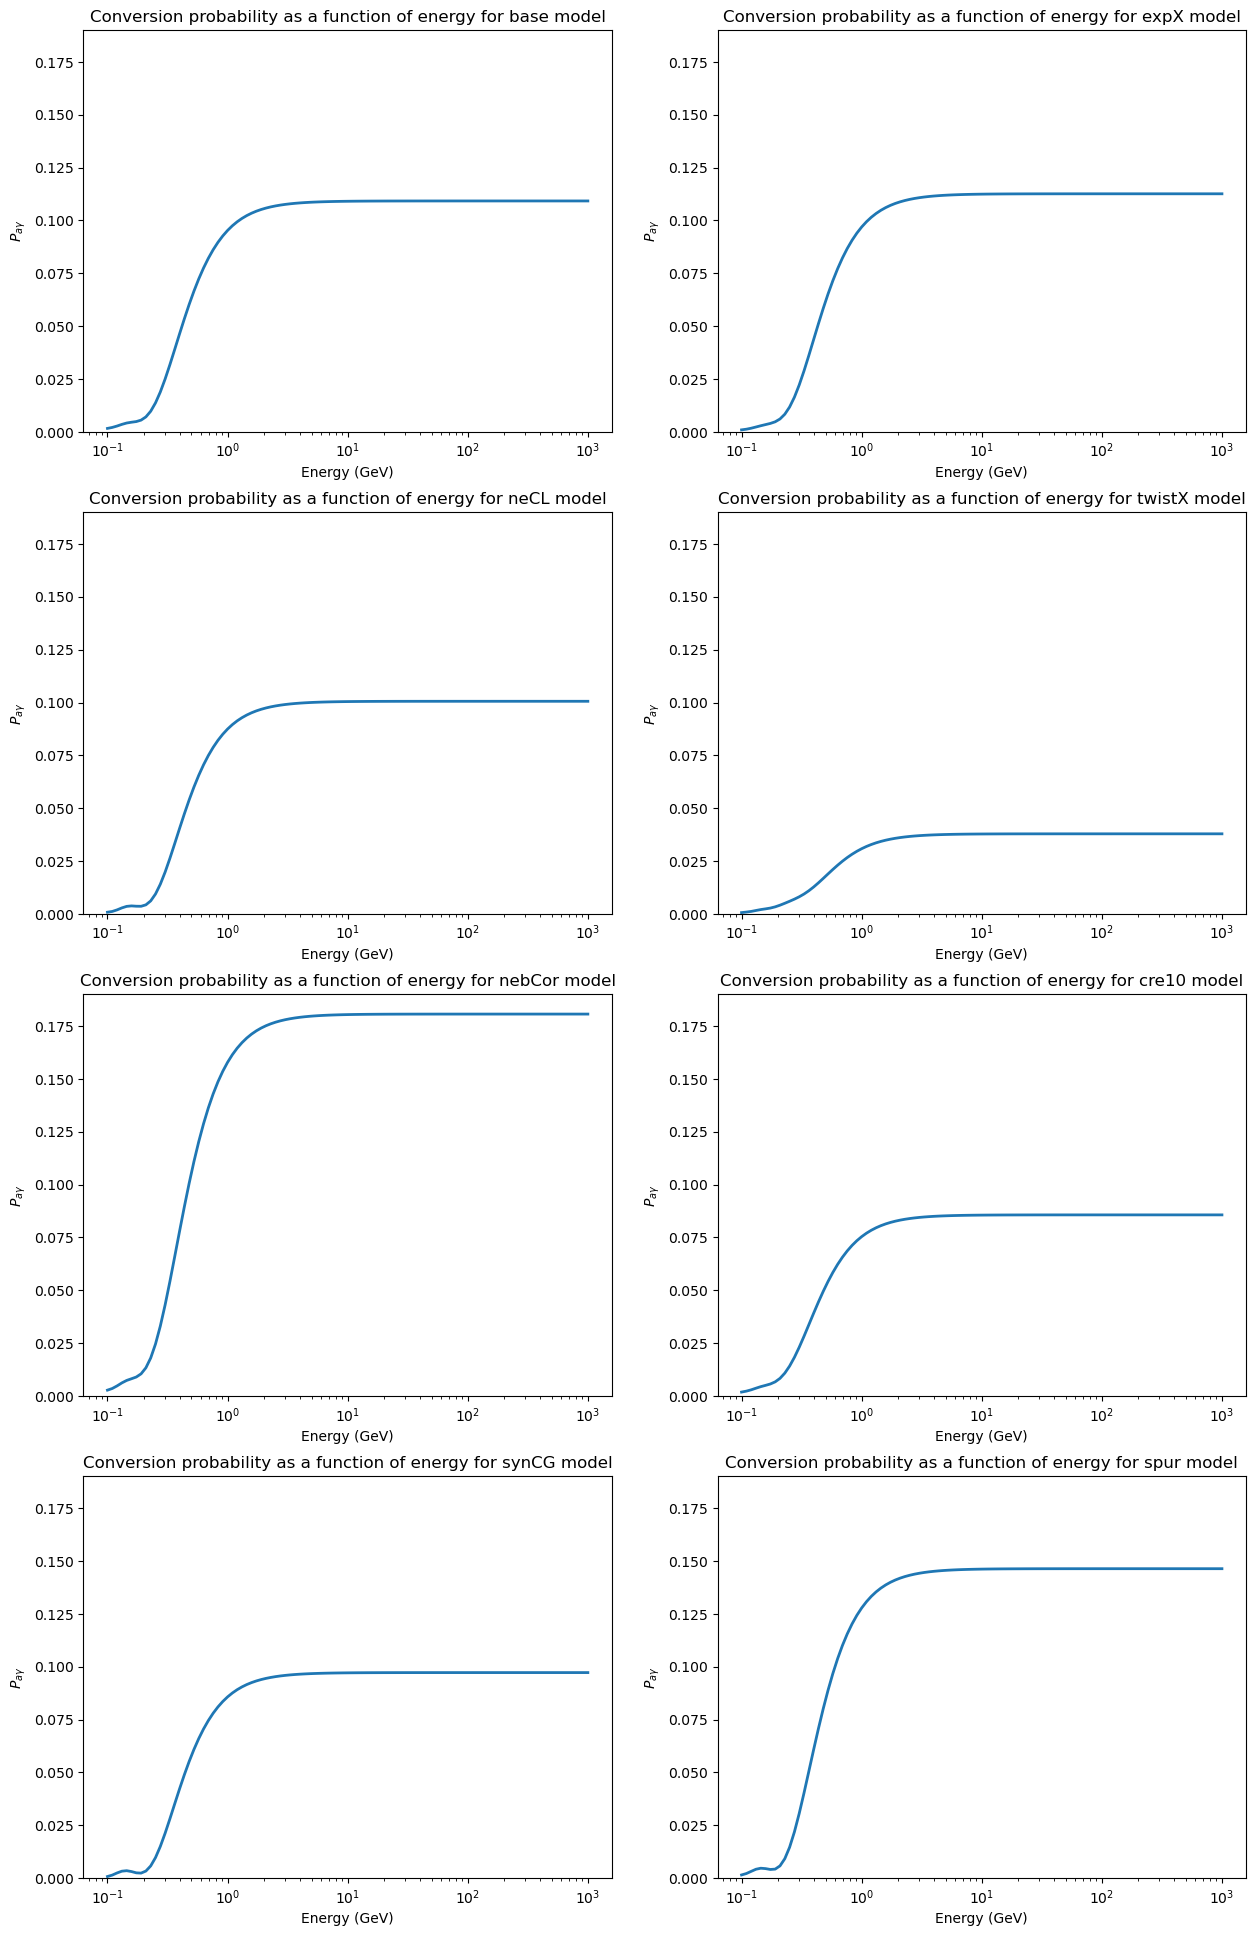

In [10]:
fig, axs = plt.subplots(4,2, figsize=(15, 24))

for i, ax in enumerate(axs.flat):
    ax.set_title(f"Conversion probability as a function of energy for {models[i]} model")
    ax.semilogx(EGeV, px[i] + py[i], lw = 2)

    ax.set_ylim(0, 0.19)
    ax.set_ylabel(r"$P_{a\gamma}$")
    ax.set_xlabel("Energy (GeV)")

plt.show()

# Sky map for mixing in the GMF

Compute Skymaps using healpy. In each sky pixel we calculate the photon-ALP conversion probability at one single energy (1 GeV).

Define the pixel grid

In [11]:
NSIDE = 7
pix = np.arange(hp.nside2npix(NSIDE))  # get the pixels
ll, bb = hp.pixelfunc.pix2ang(NSIDE, pix, lonlat=True)  #  get the galactic coordinates for each pixel
print (ll.shape)

(588,)


We loop over the coordinates and for each coordinate we re-initialize the ModuleList class and re-calculate the mixing probability

In [12]:
nm = 9

EGeV = np.array([1000.])  # energy
pgg = np.zeros((nm, pix.shape[0],EGeV.shape[0]))  # array to store the results
src = Source(z=0.1, ra=0., dec=0.)  # some random source for initialization

# coupling and mass at which we want to calculate the conversion probability:
g = 0.5
m = 1.

t1 = time.time()
for i, l in enumerate(ll):
    src.l = l
    src.b = bb[i]

    px, py, pa = np.zeros((3, nm, EGeV.size))

    ml = [ModuleList(ALP(m=m, g=g), src, pin=pa_in, EGeV=EGeV, log_level='warning') for i in range(nm)]

    models = ['base', 'expX', 'spur', 'neCL', 'twistX', 'nebCor', 'cre10', 'synCG', "jansson12"]
    for k in range(len(models)-1):
        ml[k].add_propagation("GMF", 0, model='UF23', UF23_model=models[k])
        px[k], py[k], pa[k] = ml[k].run()  # run the code
    
        pgg[k][i] = px[k] + py[k]  # save the result

    ml[8].add_propagation("GMF", 0, model='jansson12')
    px[8], py[8], pa[8] = ml[8].run()
    pgg[8][i] = px[8] + py[8]
    
    if i < ll.size - 1:
        del ml
        
t2 = time.time()
print ("It took", t2-t1, "seconds")

/afs/desy.de/user/f/flandgra/private/GMF/gammaALPs/gammaALPs/base/environs.py:1265: RuntimeWarning: divide by zero encountered in scalar divide
  self._smax = np.amin([self.__zmax/np.abs(sb),


It took 4.469395160675049 seconds


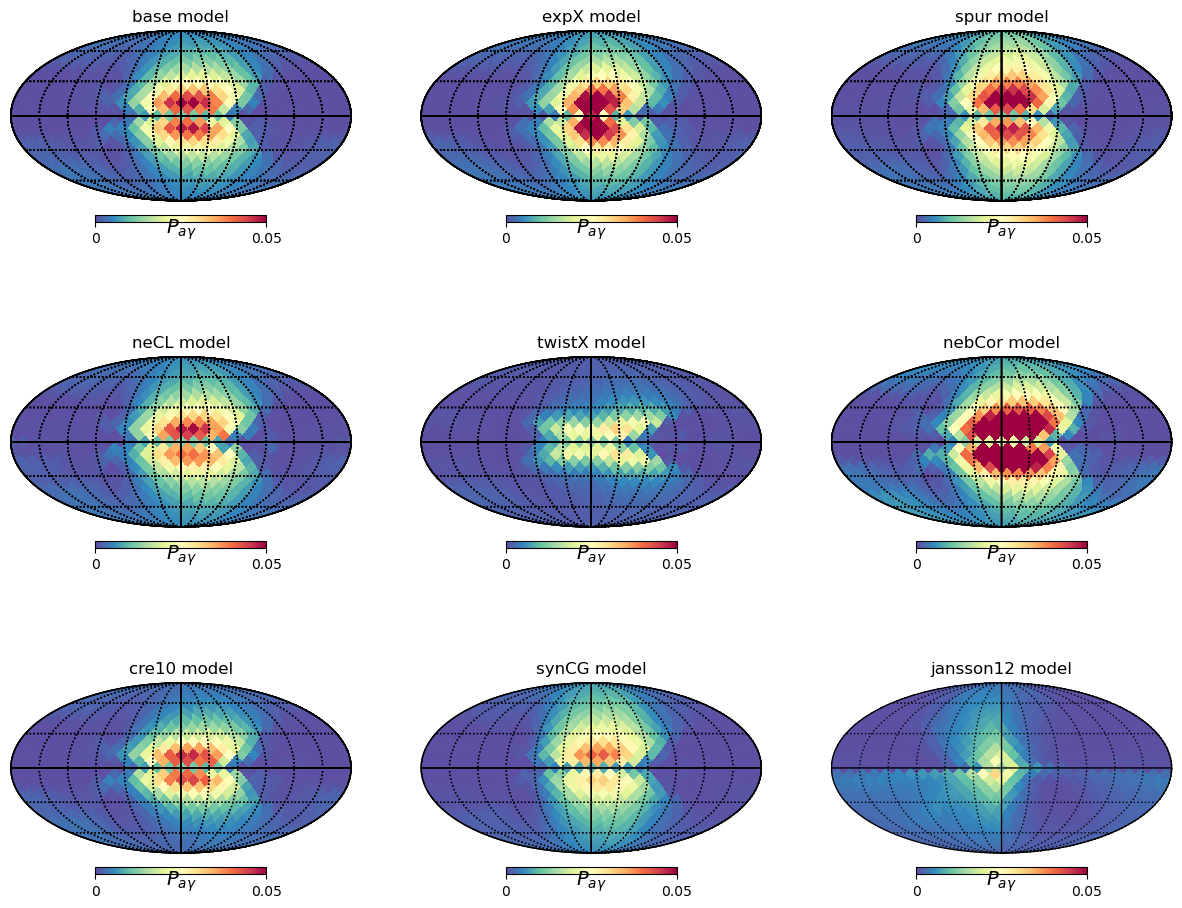

In [13]:
fig, axs = plt.subplots(3, 3, figsize=(15,12))

for k, ax in enumerate(axs.flat):
    plt.sca(ax)
    hpmap = hp.mollview(pgg[k][:,0], 
                        norm='linear',
                        title = f'{models[k]} model', 
                        unit= r'$P_{a\gamma}$', 
                        min=0,
                        max=5e-2, 
                        cmap = 'Spectral_r',
                        hold=True,
                        rot = (0, 0, 0))
    hp.graticule()
    #plt.annotate(r"$g_{{a\gamma}} = {0:.2f}\times10^{{-11}}\,\mathrm{{GeV}}^{{-1}}$".format(ml[k].alp.g),
                #xy = (0.03,0.93), xycoords = 'axes fraction', fontsize = 'x-large', **effect)

plt.show()